In [41]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as plt

from pyro.distributions import TorchDistribution
from pyro.distributions.util import broadcast_shape

In [42]:
# this is for running the notebook in our testing framework
#smoke_test = ('CI' in os.environ)
n_steps = 5000

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = 10 + dist.Normal(30, 1).sample((10,))

def model(data):
    b = pyro.sample("b", dist.HalfNormal(100.))
    x = pyro.sample("data", dist.Normal(b, 1), obs=data-10)
    
def guide(data):
    b_v = pyro.param("b_v", torch.tensor(10.), constraint=constraints.positive)
    b = pyro.sample("b", dist.Delta(b_v))

# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    
    if step % 100 == 0:
        print(pyro.param("b_v").item())

10.010004997253418
11.071823120117188
12.269909858703613
13.614556312561035
15.10996150970459
16.751005172729492
18.51820945739746
20.372270584106445
22.24984359741211
24.064455032348633
25.716995239257812
27.117311477661133
28.210615158081055
28.993581771850586
29.508563995361328
29.82164192199707
29.998878479003906
30.092899322509766
30.13983726501465
30.161949157714844
30.1717586517334
30.175874710083008
30.17746353149414
30.178068161010742
30.178068161010742
30.178068161010742
30.178068161010742
30.178075790405273
30.178091049194336
30.178104400634766
30.178119659423828
30.178133010864258
30.17814064025879
30.17815589904785
30.17816162109375
30.178176879882812
30.178184509277344
30.178190231323242
30.178197860717773
30.178205490112305
30.178213119506836
30.178220748901367
30.178226470947266
30.178234100341797
30.178241729736328
30.17824935913086
30.178255081176758
30.178255081176758
30.17826271057129
30.17827033996582


In [163]:
# this is for running the notebook in our testing framework
#smoke_test = ('CI' in os.environ)
n_steps = 5000

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = dist.Gamma(1, 0.1).sample((100,)) + dist.Normal(25, 5).sample((100,))

def model(data):
    #a = pyro.sample("a", dist.HalfNormal(30.))
    b = pyro.sample("b", dist.HalfNormal(100.))
    x = pyro.sample("data", Summed(dist.Gamma(1, 0.1), dist.Normal(b, 5)), obs=data)
    
def guide(data):
    #a_v = pyro.param("a_v", torch.tensor(10.), constraint=constraints.positive)
    b_v = pyro.param("b_v", torch.tensor(10.), constraint=constraints.positive)
    #pyro.sample("a", dist.Delta(a_v))
    pyro.sample("b", dist.Delta(b_v))

# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    
    if step % 100 == 0:
        print(pyro.param("b_v").item())

10.010004997253418
11.07103443145752
12.237306594848633
13.543619155883789
14.96059513092041
16.466169357299805
18.00245475769043
19.540576934814453
20.916414260864258
22.10936737060547
23.163105010986328
23.854616165161133
24.43291473388672
24.675992965698242
24.785066604614258
24.820056915283203
24.90951919555664
24.999971389770508
24.919349670410156
24.930034637451172
25.014114379882812
24.85936737060547
24.878538131713867
24.989168167114258
25.021886825561523
24.925695419311523
24.948394775390625
25.066316604614258
25.00370979309082
25.129709243774414
24.834991455078125
25.11966323852539
24.891233444213867
25.01214027404785
24.877113342285156
25.0006160736084
24.856386184692383
24.82415771484375
24.809253692626953
25.05585289001465
24.84496307373047
24.964937210083008
25.03502655029297
24.9835205078125
25.02655792236328
24.99386215209961
25.01921272277832
24.860980987548828
25.022518157958984
24.99283790588379


In [74]:
class Summed(TorchDistribution):
    def __init__(self, component0, component1, validate_args=None):
        if component0.event_shape != component1.event_shape:
            raise ValueError('components event_shape disagree: {} vs {}'
                             .format(component0.event_shape, component1.event_shape))
        batch_shape = broadcast_shape(component0.batch_shape, component1.batch_shape)
        if component0.batch_shape != batch_shape:
            component0 = component0.expand(batch_shape)
        if component1.batch_shape != batch_shape:
            component1 = component1.expand(batch_shape)

        self.component0 = component0
        self.component1 = component1
        super().__init__(batch_shape, component0.event_shape, validate_args)

        # We need to disable _validate_sample on each component since samples are only valid on the
        # component from which they are drawn. Instead we perform validation using a MaskedConstraint.
        self.component0._validate_args = False
        self.component1._validate_args = False

    @property
    def has_rsample(self):
        return self.component0.has_rsample and self.component1.has_rsample

    @constraints.dependent_property
    def support(self):
        if self.component0.support is self.component1.support:
            return self.component0.support
        return MaskedConstraint(self.mask, self.component0.support, self.component1.support)

    def expand(self, batch_shape):
        try:
            return super().expand(batch_shape)
        except NotImplementedError:
            component0 = self.component0.expand(batch_shape)
            component1 = self.component1.expand(batch_shape)
            return type(self)(component0, component1)


    def sample(self, sample_shape=torch.Size()):
        result = (self.component1.rsample(sample_shape)
                 + self.component0.rsample(sample_shape))
        return result


    def rsample(self, sample_shape=torch.Size()):
        result = (self.component1.rsample(sample_shape)
                 + self.component0.rsample(sample_shape))
        return result


    def log_prob(self, value, num_particles=1):
        value_shape = broadcast_shape(value.shape, self.batch_shape + self.event_shape)
        if value.shape != value_shape:
            value = value.expand(value_shape)
        if self._validate_args:
            self._validate_sample(value)
        x = self.component0.sample((num_particles,) + value_shape)
        result = self.component1.log_prob(value - x)
        mask = result.isinf() | result.isnan()
        result = result.masked_fill(mask, -40.)
        return torch.logsumexp(result, 0) - torch.log(torch.tensor(num_particles).float())

In [85]:
#d = Summed(dist.Gamma(150 * 0.01, 0.01), dist.HalfNormal(10000.*0.04))
d = Summed(dist.Gamma(190 * 10, 10), dist.Gamma(10.*0.1, 0.1))

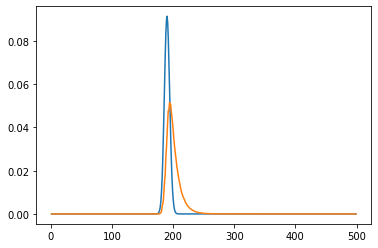

In [86]:
#plt.hist(d.sample((1000,)).numpy(), bins=30, alpha=0.3, density=True)
#plt.hist(dist.Gamma(1, 0.1).sample((500,)).numpy(), bins=30, alpha=0.3, density=True)
#plt.hist(dist.Normal(30, 5).sample((500,)).numpy(), bins=30, alpha=0.3, density=True)
#plt.plot(torch.arange(10, 80, 1), d.log_prob(torch.arange(10, 80, 1), 10).exp())
#plt.plot(torch.arange(10, 80, 1), d.log_prob(torch.arange(10, 80, 1), 100).exp())
plt.plot(torch.arange(1, 500, 1), dist.Gamma(190 * 10, 10).log_prob(torch.arange(1, 500, 1)).exp())
plt.plot(torch.arange(1, 500, 1), d.log_prob(torch.arange(1, 500, 1), 1000).exp())
plt.show()

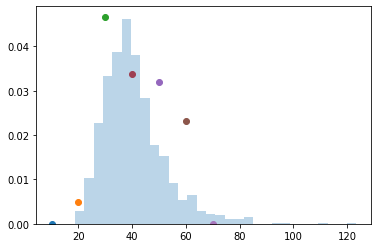

In [123]:
plt.hist(d.sample((1000,)).numpy(), bins=30, alpha=0.3, density=True)
#plt.hist(dist.Gamma(1, 0.1).sample((500,)).numpy(), bins=30, alpha=0.3, density=True)
#plt.hist(dist.Normal(30, 5).sample((500,)).numpy(), bins=30, alpha=0.3, density=True)
plt.scatter(10, torch.logsumexp(d.log_prob(torch.ones(3)*10), 0).exp() / 3)
plt.scatter(20, torch.logsumexp(d.log_prob(torch.ones(3)*20), 0).exp() / 3)
plt.scatter(30, torch.logsumexp(d.log_prob(torch.ones(3)*30), 0).exp() / 3)
plt.scatter(40, torch.logsumexp(d.log_prob(torch.ones(3)*40), 0).exp() / 3)
plt.scatter(50, torch.logsumexp(d.log_prob(torch.ones(3)*50), 0).exp() / 3)
plt.scatter(60, torch.logsumexp(d.log_prob(torch.ones(3)*60), 0).exp() / 3)
plt.scatter(70, torch.logsumexp(d.log_prob(torch.ones(3)*70), 0).exp() / 3)
plt.show()

In [2]:
from cosmos.distributions import ConvDist
from cosmos.models import Tracker
from pyro import param

In [3]:
name = "15"
path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
path_params = "/shared/centaur/data/lamda_data/h3000pi15lamda{}/runs/tracker/v1.1.4noise/S1/nocontrol/lr0.005/bs5".format(name)
model = Tracker(S=1)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

In [4]:
gauss = model.data_loc(
    param("d/w_mode").data[0, 3, 5],
    param("d/x_mode").data[0, 3, 5],
    param("d/y_mode").data[0, 3, 5],
    3, 5)

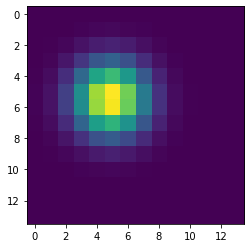

In [5]:
plt.imshow(gauss)

In [6]:
s = ConvDist(
    dist.Gamma(150*0.1, 0.1).expand([14, 14]).to_event(2),
    dist.HalfNormal(5000),
    gauss
)

In [7]:
x = s.sample()

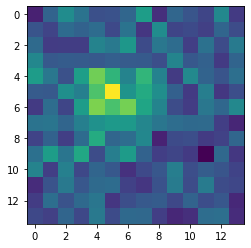

In [8]:
plt.imshow(x)

In [9]:
x

tensor([[ 86.3814, 163.9501, 221.2661, 184.6517, 137.9197, 141.3549, 168.0607,
         244.7863, 101.4181, 167.3192, 145.1679, 126.5287, 213.8988, 113.3902],
        [143.4962, 125.4525, 174.8096, 162.0177, 176.3613, 130.9521, 184.7683,
         109.8234, 221.5743, 126.2814, 131.2645, 120.3279, 166.8120, 134.6771],
        [173.1785, 116.0162, 116.6236, 117.6979, 208.2619, 193.4082, 235.7558,
         133.3531, 189.9941, 176.2583, 118.0241, 182.6942, 132.8091, 194.3989],
        [212.4881, 150.7862, 154.8448, 152.5751, 150.0890, 158.3329, 152.8129,
         151.9001, 136.9883, 208.8951, 149.3323, 161.2059, 113.1578, 165.4925],
        [244.1324, 190.3457, 139.3706, 246.0350, 322.1423, 278.4804, 207.9081,
         279.9957, 205.8651, 114.5699, 215.1672, 163.1482, 144.3512, 180.1609],
        [153.5385, 149.9922, 225.1786, 202.5676, 301.1503, 395.8558, 230.8786,
         262.9355, 224.2812, 159.9215, 113.7306, 201.1104, 110.1626, 137.1151],
        [113.3178, 176.7282, 126.2420, 242.983

In [10]:
s.component1()

tensor(1125.9320)

In [14]:
s.log_prob(x)

tensor(-988.4022)

In [35]:
d = dist.Gamma(torch.ones(3,2)[..., None,None], 1).expand([3,2,4,4]).to_event(2)

In [38]:
d.sample()

tensor([[[[0.7823, 0.2063, 0.0095, 0.0683],
          [0.8922, 0.2927, 0.1696, 2.7878],
          [0.0276, 0.3228, 0.3298, 0.3198],
          [2.5647, 0.5065, 0.9702, 0.8947]],

         [[0.0392, 0.3582, 0.2160, 3.4198],
          [0.8534, 1.9802, 0.1567, 0.2568],
          [0.4537, 0.8823, 0.3364, 1.0445],
          [0.6780, 0.5451, 0.0867, 0.3965]]],


        [[[0.6425, 0.7235, 0.5661, 1.0608],
          [2.3342, 1.0646, 0.6672, 1.5934],
          [0.2526, 1.1051, 0.5492, 3.1297],
          [0.2413, 1.3539, 0.3379, 0.2559]],

         [[3.3104, 0.1435, 1.2995, 0.5734],
          [0.2174, 1.7269, 0.1408, 2.0060],
          [0.9964, 1.5716, 0.5305, 0.1205],
          [0.6738, 3.1205, 0.1220, 0.1460]]],


        [[[1.7042, 1.0730, 2.1240, 0.7719],
          [1.3102, 0.6748, 2.4547, 0.0293],
          [1.7903, 0.5577, 0.6742, 1.5630],
          [0.3216, 1.7247, 0.3671, 0.0150]],

         [[0.5907, 0.1029, 0.1509, 0.1721],
          [0.2730, 3.0737, 0.4163, 1.1673],
          [1.2884,

In [25]:
torch.ones(3).size() + (2,2)

torch.Size([3, 2, 2])